## Data Loading

In [42]:
# !pip install polars
# !pip install umap-learn

Исходный файл с embedding-векторами содержит очень большое количество данных — порядка 16 ГБ на диске.
Важно понимать, что размер файла ≠ размер в оперативной памяти.
При загрузке векторных данных в RAM их объём обычно увеличивается, поскольку:

* данные раскодируются из колоннарного формата Parquet,
* создаются внутренние структуры DataFrame,
* происходит выравнивание/оптимизация типов.

В итоге фактическое потребление памяти может быть в 1.5–3 раза выше, чем вес файла.

Чтобы работать с данными без полной загрузки всего массива в память, используется библиотека Polars. Она поддерживает ленивое выполнение, построчное сканирование Parquet-файлов, выборку только нужного числа строк и при этом обеспечивает высокую скорость и низкое потребление памяти благодаря реализации на Rust. Всё это позволяет эффективно обрабатывать большие датасеты, не превышая ограничений оперативной памяти.

In [1]:
import polars as pl

def estimate_parquet_ram_usage(path: str, sample_rows: int = 10_000):
    print(f"\n📁 Файл: {path}")
    print(f"📊 Сэмпл строк: {sample_rows:,}")

    # читаем sample
    df_sample = pl.read_parquet(path, n_rows=sample_rows)
    size_sample = df_sample.estimated_size()
    print(f"🔹 Размер sample: {size_sample/1024**2:.2f} MB")

    # ленивое сканирование для подсчёта строк
    lf = pl.scan_parquet(path)
    total_rows = lf.select(pl.len()).collect().item()
    print(f"🔹 Всего строк в файле: {total_rows:,}")

    # оценка общего размера
    estimated_total_bytes = size_sample * (total_rows / sample_rows)
    estimated_total_gb = estimated_total_bytes / 1024**3

    print(f"\n📐 Примерная оценка объёма данных в памяти: {estimated_total_gb:.2f} GB")



# пример использования
estimate_parquet_ram_usage("../data/embeddings.parquet")



📁 Файл: ../data/embeddings.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 117.38 MB
🔹 Всего строк в файле: 7,721,749

📐 Примерная оценка объёма данных в памяти: 88.51 GB


В данном проекте используется только подмножество данных — датасет на 50 миллионов записей.
Поэтому на первой итерации мы извлекаем только нужный сегмент, не работая со всем большим embedding-файлом.

In [2]:
import pandas as pd


multi_event_50M = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet", columns=["item_id"])
embed_5b = pl.scan_parquet("../data/embeddings.parquet")

total_embeddings_rows = embed_5b.select(pl.len()).collect().item()  # Предполагается, что они все уникальные :)
unique_item_ids_50M = multi_event_50M["item_id"].nunique()

ratio = (unique_item_ids_50M / total_embeddings_rows) * 100


print(f"Используемое количество данные в 50M: {round(ratio, 2)}%")


Используемое количество данные в 50M: 12.1%


Так как мы используем лишь 12% исходного датасета, мы сразу отбираем только нужные записи и сохраняем их в отдельный файл, уменьшая объём данных и ускоряя последующую обработку.

In [9]:
import time
start = time.time()

unique_item_50M = multi_event_50M["item_id"].unique().tolist()

(
    embed_5b
    .filter(pl.col("item_id").is_in(unique_item_50M))
    .sink_parquet("filtered_embeddings.parquet")
)

end = time.time()
duration = end - start

print(f"⏱ Фильтрация и сохранение завершены за {duration:.2f} сек ({duration/60:.2f} мин).")

⏱ Фильтрация и сохранение завершены за 212.92 сек (3.55 мин).


## Data Cleaning

### Фильтрация дублей по embeddings

Проверим нет ли дубликатов embeddings

In [25]:
embed_df = pl.scan_parquet("filtered_embeddings.parquet")

dupes = (
    embed_df
    .with_columns(pl.col("embed").hash().alias("h"))
    .group_by("h")
    .agg([
        pl.len().alias("dup_count"),
        pl.col("item_id").alias("item_ids"),   
    ])
    .filter(pl.col("dup_count") > 1)
    .collect(engine="streaming") 
)

dupes



h,dup_count,item_ids
u64,u32,list[u32]
2833615793745376201,2,"[1147108, 4096388]"
6853723085163307689,2,"[4340639, 5110655]"
8075462634677102445,2,"[2260752, 3818593]"
12602122677565559315,2,"[4235422, 7125134]"
11267668079004336834,2,"[1694243, 8496261]"
…,…,…
3921963202574077658,2,"[1393313, 5978692]"
7851075014094279059,2,"[1665619, 6441249]"
10944765622232567853,2,"[6381614, 7764951]"


В данных присутствуют дубликаты — вероятно, одна и та же песня была загружена под разными item_id. Процент повторов составляет около 1.7%: показатель небольшой, но всё же достаточно значимый, чтобы их исключить.

Чтобы корректно обработать эту ситуацию, создадим JSON-карту соответствий, где для каждой группы дублей будет выбран один “эталонный” item_id. Остальные идентификаторы будут сопоставлены с ним как эквивалентные.

In [29]:
per_of_dup = sum(dupes["dup_count"])/ unique_item_ids_50M *100
print(f"Процент дубликатов {round(per_of_dup, 2)}%")

Процент дубликатов 1.71%


In [32]:
import json


# Все item_id в датасете
all_items = set(unique_item_50M)

mapping = {}

# 1. Обрабатываем дубли: каждый id → canonical
for group in dupes["item_ids"]:
    canonical_id = group[0]
    for item_id in group:
        mapping[item_id] = canonical_id

# 2. Добавляем недостающие id как identity mapping
for item_id in all_items:
    if item_id not in mapping:
        mapping[item_id] = item_id

# Сохраняем в JSON
output_path = "item_id_mapping.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(mapping, f, ensure_ascii=False, indent=4)

print(f"✔ Mapping сохранён в '{output_path}'")
print(f"🔹 Всего item_id в датасете: {len(all_items):,}")
print(f"🔹 Записей в итоговом mapping: {len(mapping):,}")

✔ Mapping сохранён в 'item_id_mapping.json'
🔹 Всего item_id в датасете: 934,057
🔹 Записей в итоговом mapping: 934,057


### Фильтрация дублей по item_id

In [12]:
embed_df = pl.scan_parquet("filtered_embeddings.parquet")

dupes = (
    embed_df
    .with_columns(pl.col("embed").hash().alias("h"))
    .group_by("h")
    .agg([
        pl.len().alias("dup_count"),
        pl.col("item_id").alias("item_ids"),   
    ])
    .filter(pl.col("dup_count") > 1)
    .collect(engine="streaming") 
)

dupes

h,dup_count,item_ids
u64,u32,list[u32]
9079638452460116477,2,"[4757992, 6156435]"
5377353581306548589,2,"[4096864, 8195897]"
8894807848111532958,2,"[1241744, 7239896]"
5715412884990321596,4,"[1113757, 2131428, … 8617353]"
14560092848069229989,2,"[7622441, 9319657]"
…,…,…
16326518871983664726,2,"[2890165, 7575318]"
976088310256915929,2,"[1901030, 5514170]"
13246534090568757572,2,"[4650842, 5655792]"


Дублей по item_id не нашлось

## Кластеризация

Была попытка построить рекомендательную систему по эмбедингам, но точность оказалась крайне маленькой. На хабре в статье от ВК нашла информацию, что лучше сначала проводить кластеризацию данных, делать по жанрам (что в целом логично :D ) https://habr.com/ru/companies/vk/articles/683152/ 

Попытки кластеризовать все и сразу не увенчались удачей. Поэтому появилась идея кластеризовать пачками - но не рандомно, а по артистам. Как правильно одна группа/артист пишут музыку в одном стиле

#### Кластеризация всей музыки

In [4]:
# пример использования
estimate_parquet_ram_usage("filtered_embeddings.parquet")


📁 Файл: filtered_embeddings.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 117.38 MB
🔹 Всего строк в файле: 847,921

📐 Примерная оценка объёма данных в памяти: 9.72 GB


In [1]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 17.9 MB/s  0:00:00 5.7 MB/s eta 0:00:01


In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import umap
import hdbscan
import polars as pl

import numpy as np
from umap.umap_ import UMAP



embd = pl.scan_parquet("filtered_embeddings.parquet") #.filter(pl.col("item_id").is_in(all_items))
items_meta = pl.scan_parquet("../data/items_meta.parquet")

df_merged = embd.join(
    items_meta.select(["item_id", "artist_id", "album_id"]),
    on="item_id",
    how="left",
)

artist_meta = (
    pl.scan_parquet("../data/items_meta.parquet")
    .select(["artist_id", "item_id"])
    .unique()
    .group_by("artist_id")
    .agg(pl.col("item_id").alias("items"))
    .collect()

)

/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
artist_meta

artist_id,items
f64,list[u32]
1.08943e6,"[6619127, 2091564]"
890911.0,[5016519]
455924.0,[4952650]
177767.0,[9116714]
395315.0,[2922222]
…,…
251759.0,"[9299371, 4539526, … 1563061]"
402170.0,[2031698]
584631.0,[3371610]


In [62]:
# target_items = [item for sublist in artist_meta["items"][:1000] for item in sublist]
# target_items = [item for sublist in artist_meta["items"][:1000] for item in sublist]
target_items = [item for sublist in artist_meta.filter(pl.col("artist_id").is_in([51490.0, 40283.0]))["items"] for item in sublist]


current_emb = df_merged.filter(pl.col("item_id").is_in(target_items)).collect()


embeddings = current_emb["normalized_embed"].to_list()
embeddings = np.array(embeddings, dtype="float32")

artist = current_emb["artist_id"].to_list()


np.random.seed(42)



In [63]:

# Снижение размерности для визуализации
# pca = PCA(n_components=20)
# embeddings_2d = pca.fit_transform(embeddings)


# --- UMAP ---
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

embeddings_2d = umap_model.fit_transform(embeddings)


/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [64]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)


# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=30,
#     min_samples=10,
#     metric='euclidean',  # или 'euclidean', зависит от эмбеддингов
#     cluster_selection_method='eom'
# )

# labels = clusterer.fit_predict(embeddings)  # кластеризация на исходных данных

In [17]:
# unique_labels

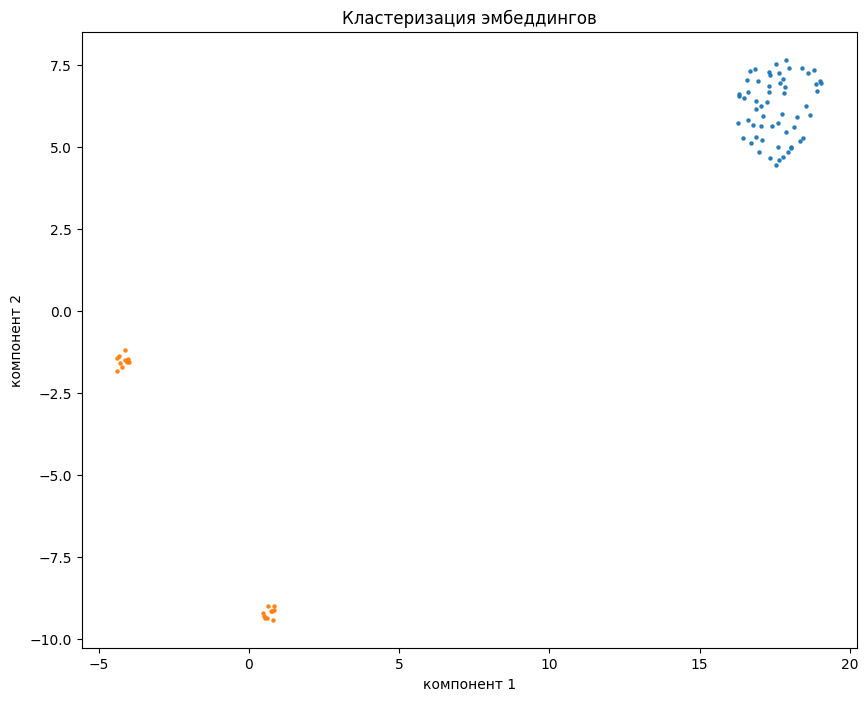

In [65]:
plt.figure(figsize=(10, 8))


unique_labels = list(set(labels))

for cluster_id in unique_labels:
    cluster_points = embeddings_2d[labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=5,
        alpha=0.9,
        label=f'Кластер {cluster_id}'
    )
# plt.legend()
plt.title('Кластеризация эмбеддингов')
plt.xlabel('компонент 1')
plt.ylabel('компонент 2')
plt.show()

In [66]:
import pandas as pd
df = pd.DataFrame({"labels": labels,
                  "artist": artist})


In [67]:
artist_stats = (
    df.groupby("artist")
      .agg(
          total_tracks=("labels", "count"),
          n_clusters=("labels", "nunique"),
      )
      .reset_index()
)

artist_stats[artist_stats["n_clusters"] >1]

,artist,total_tracks,n_clusters


#### Кластеризация для одного пользователя

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import umap
import hdbscan
import polars as pl

import numpy as np
from umap.umap_ import UMAP

df = pl.scan_parquet("../data/multi_event.parquet")

most_frequent_uid = (
    df
    .group_by("uid")
    .agg(pl.count().alias("cnt"))
    .sort("cnt", descending=True)
    .limit(1)
    .collect()
)

most_frequent_uid

/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_47537/2825915804.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("cnt"))


uid,cnt
u32,u32
997500,27699


In [3]:
items_of_most_popular_user = pl.scan_parquet("../data/multi_event.parquet").filter(pl.col("uid") == 997500).select("item_id").collect().to_series().to_list()
items_of_most_popular_user[:10]

[4523558,
 2880664,
 8918616,
 4582816,
 4308191,
 331232,
 6792265,
 960603,
 9259895,
 4761760]

In [32]:
embd_of_most_popular_user = pl.scan_parquet("filtered_embeddings.parquet").filter(pl.col("item_id").is_in(items_of_most_popular_user)).collect()

embeddings = embd_of_most_popular_user["normalized_embed"].to_list()
embeddings = np.array(embeddings, dtype="float32")

np.random.seed(42)

In [33]:

# global_mean_embed = np.mean(embeddings, axis=0)  # будет shape (D,)
# embeddings = np.concatenate([embeddings, [global_mean_embed]])

# --- UMAP ---
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=3,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

embeddings_2d = umap_model.fit_transform(embeddings)


/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.7 MB/s  0:00:01 eta 0:00:010:00:01


In [18]:
import sklearn_extra
print(sklearn_extra.__version__)

0.3.0


In [34]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)


# from sklearn_extra.cluster import SphericalKMeans

# num_clusters = 6

# # если эмбеддинги ещё не нормированы:
# # from sklearn.preprocessing import normalize
# # embeddings = normalize(embeddings, norm="l2", axis=1)

# skm = SphericalKMeans(
#     n_clusters=num_clusters,
#     random_state=42,
#     n_init=10,
# )
# labels = skm.fit_predict(embeddings)



# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=30,
#     min_samples=10,
#     metric='euclidean',  # или 'euclidean', зависит от эмбеддингов
#     cluster_selection_method='eom'
# )

# labels = clusterer.fit_predict(embeddings)  # кластеризация на исходных данных

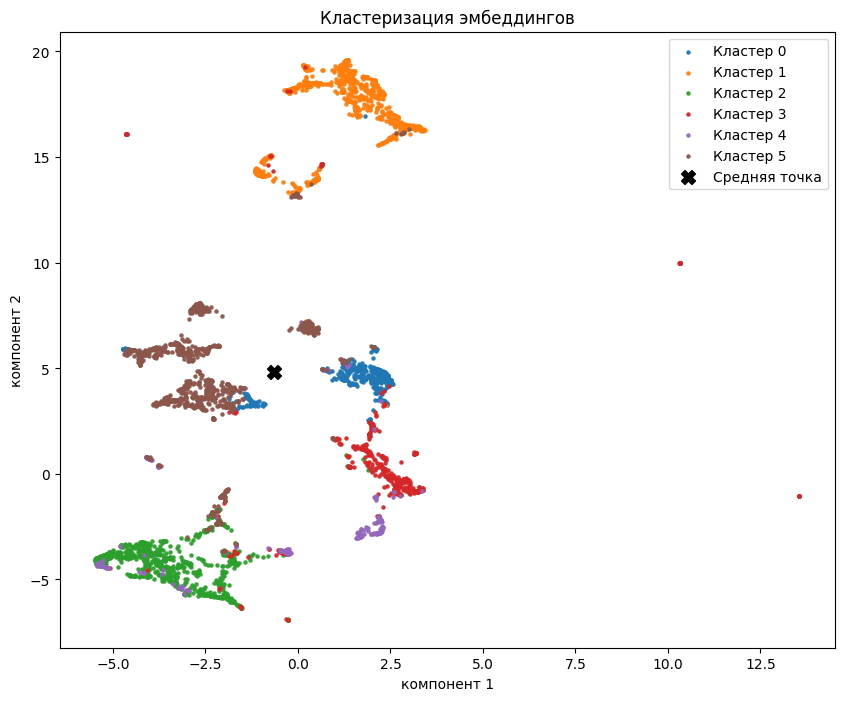

In [39]:
plt.figure(figsize=(10, 8))

global_mean_embed_2d = np.mean(embeddings_2d, axis=0)  # будет shape (D,)
unique_labels = list(set(labels))

for cluster_id in unique_labels:
    cluster_points = embeddings_2d[labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=5,
        alpha=0.9,
        label=f'Кластер {cluster_id}'
    )


# Средняя точка всех embeddings
plt.scatter(
    global_mean_embed_2d[0],
    global_mean_embed_2d[1],
    s=100,
    color='black',
    marker='X',
    label='Mean embedding'
)


    
plt.legend()
plt.title('Кластеризация эмбеддингов')
plt.xlabel('компонент 1')
plt.ylabel('компонент 2')
plt.show()

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # нужно, чтобы заработала 3D-проекция


# ===== Вспомогательные функции =====

def l2_normalize_rows(X, eps=1e-12):
    """
    Нормируем каждую строку до единичной L2-нормы (||x|| = 1).
    """
    X = np.asarray(X)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms


def spherical_kmeans(X, n_clusters, max_iter=100, tol=1e-6, random_state=None):
    """
    Сферический k-means с косинусной мерой (для данных на сфере).

    Параметры:
        X : np.ndarray, shape (n_samples, n_features)
        n_clusters : int
        max_iter : int
        tol : float
        random_state : int | None

    Возвращает:
        labels : (n_samples,)
        centers : (n_clusters, n_features)
    """
    rng = np.random.default_rng(random_state)

    # Нормируем объекты до длины 1
    X_norm = l2_normalize_rows(X)
    n_samples, n_features = X_norm.shape

    # Инициализация центров: случайные объекты
    indices = rng.choice(n_samples, size=n_clusters, replace=False)
    centers = X_norm[indices].copy()

    for it in range(max_iter):
        # Косинусная схожесть: скалярное произведение (все нормированы)
        similarities = X_norm @ centers.T  # (n_samples, n_clusters)
        labels = similarities.argmax(axis=1)

        new_centers = np.zeros_like(centers)
        for k in range(n_clusters):
            cluster_points = X_norm[labels == k]
            if len(cluster_points) == 0:
                # Пустой кластер — случайно перезапускаем
                new_centers[k] = X_norm[rng.integers(0, n_samples)]
            else:
                mean_vec = cluster_points.mean(axis=0)
                new_centers[k] = mean_vec / max(np.linalg.norm(mean_vec), 1e-12)

        shift = np.linalg.norm(centers - new_centers)
        centers = new_centers

        if shift < tol:
            # print(f"Converged at iter {it}, shift={shift}")
            break

    return labels, centers


import numpy as np
import plotly.graph_objects as go


import numpy as np
import plotly.graph_objects as go


def plot_clusters_3d_on_sphere(
    X,
    labels,
    center,
    title="Spherical k-means 3D",
    width=1200,
    height=900
):
    """
    Большой 3D-график кластеров на сфере (Plotly).

    width, height — размер графика в пикселях.
    """
    X = np.asarray(X)
    labels = np.asarray(labels)

    if X.shape[1] != 3:
        raise ValueError("X должен иметь форму (n_samples, 3)")

    # ---- сфера ----
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 60)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    sphere_surface = go.Surface(
        x=xs,
        y=ys,
        z=zs,
        opacity=0.15,
        showscale=False
    )

    # ---- точки ----
    points_trace = go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode="markers",
        marker=dict(
            size=4,
            color=labels,
            colorscale="Viridis",
            opacity=0.85
        ),
        name="points"
    )

    traces = [sphere_surface, points_trace]

    # ---- центр ----
    if center:
                # глобальный центр
        global_mean_embed_3d = np.mean(X, axis=0)
    
        # ---- нормализация на сферу ----
        norm = np.linalg.norm(global_mean_embed_3d)
        if norm == 0:
            center_vec = global_mean_embed_3d
        else:
            center_vec = global_mean_embed_3d / norm
        
        centers_trace = go.Scatter3d(
            x=[center_vec[0]],
            y=[center_vec[1]],
            z=[center_vec[2]],
            mode="markers",
            marker=dict(
                size=10,
                symbol="x",
                color="red",
                line=dict(width=3, color="black"),
            ),
            name="centers"
        )
        traces.append(centers_trace)

    fig = go.Figure(data=traces)
    
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="cube"
        ),
        margin=dict(l=10, r=10, t=50, b=10),
        showlegend=True
    )
    fig.show()

In [49]:
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=3,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

embeddings_3d = umap_model.fit_transform(embeddings)

/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


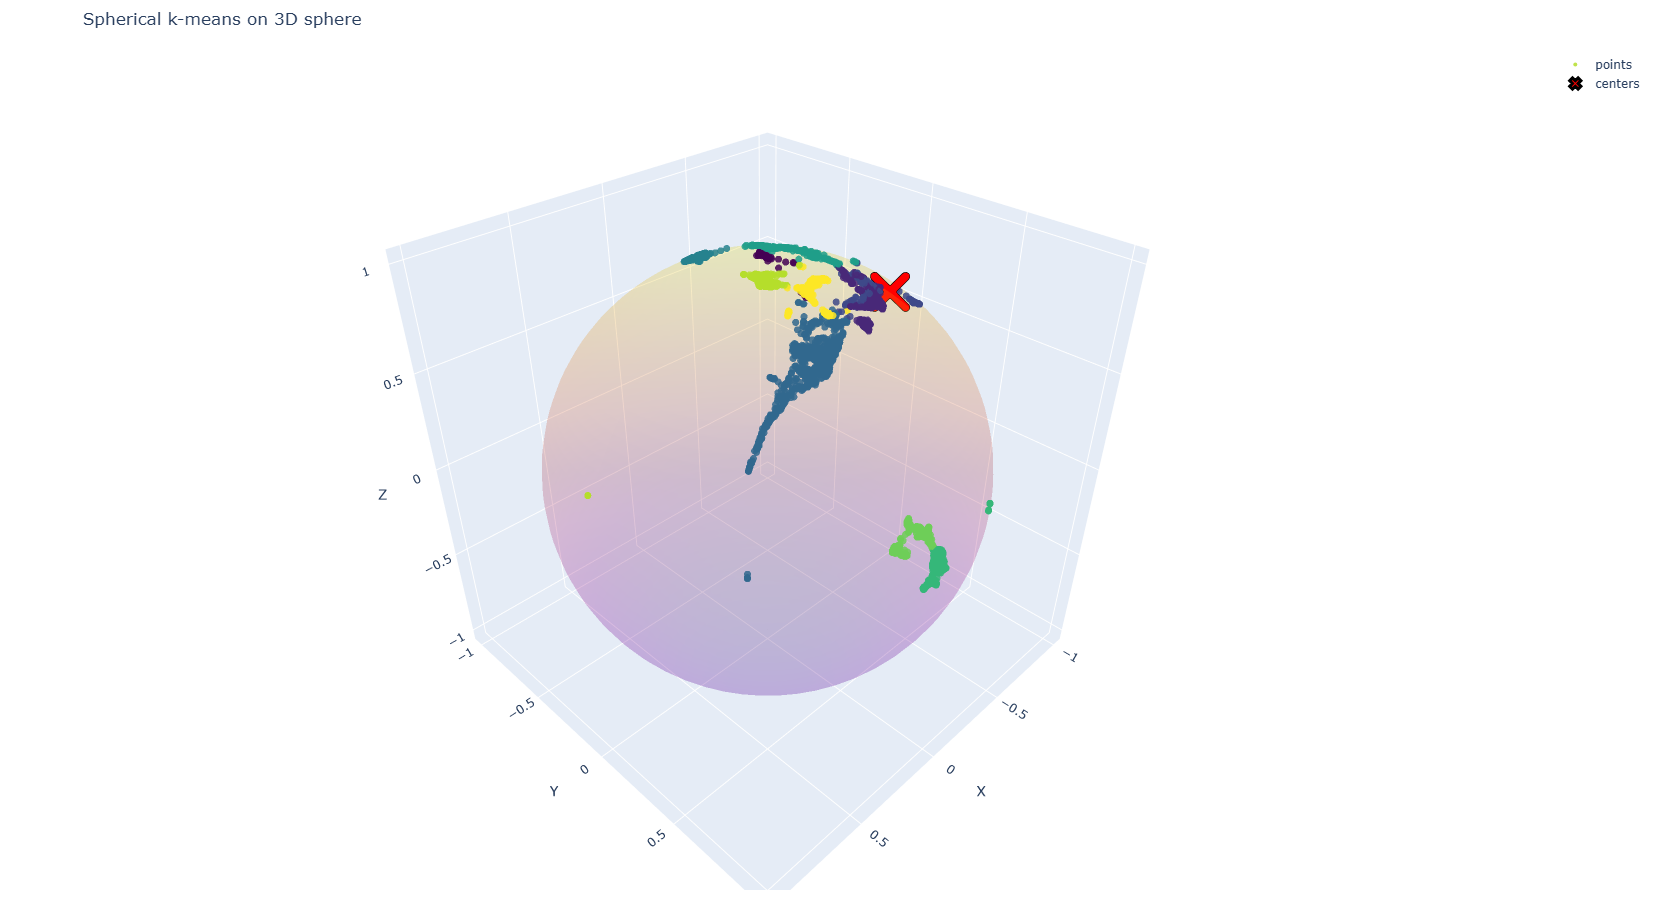

In [93]:
rng = np.random.default_rng(0)

n_samples = 300
n_clusters = 10

true_dirs = l2_normalize_rows(embeddings_3d)

labels, _ = spherical_kmeans(true_dirs, n_clusters=n_clusters, max_iter=100, random_state=42)

# Визуализация на сфере
plot_clusters_3d_on_sphere(true_dirs, labels, True, title="Spherical k-means on 3D sphere")

На графике крестиком показано, где бы приблизитльно был бы профильный вектор пользовтеля, если бы мы брали среднее по всем векторам. 
Наиболее оптимальным подходом будет сначала кластеризовать, брать по каждой группе свой вектор и уже отталкиваясь от него искать похожие песни 